# Trabalho 03 - Aprendizado de Máquina
## Aluno: Ruan Felipe de Almeida Silva - 397048

### Problema:

Este dataset apresenta um conjunto de informações referentes a leilões, de modo a averiguar se nestes leilões, ocorreu o caso de lances serem ofertados propositalmente por um licitante para aumentar o preço do produto, o que é conhecido como licitação Shill e que é ilegal em várias partes do mundo.

In [371]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [372]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings('ignore')

### Importando os dados do dataset

In [373]:
dataframe = pd.read_csv('/content/drive/MyDrive/ufc - ec/Aprend_Maquina/datasets/Shill Bidding Dataset.csv')
#dataframe = pd.read_csv('Shill Bidding Dataset.csv')
dataframe

Record_ID  Auction_ID Bidder_ID  ...  Winning_Ratio  Auction_Duration  Class
0             1         732     _***i  ...       0.666667                 5      0
1             2         732     g***r  ...       0.944444                 5      0
2             3         732     t***p  ...       1.000000                 5      0
3             4         732     7***n  ...       1.000000                 5      0
4             5         900     z***z  ...       0.500000                 7      0
...         ...         ...       ...  ...            ...               ...    ...
6316      15129         760     l***t  ...       0.888889                 3      1
6317      15137        2481     s***s  ...       0.878788                 7      0
6318      15138        2481     h***t  ...       0.000000                 7      0
6319      15139        2481     d***d  ...       0.000000                 7      0
6320      15144        2481     a***l  ...       0.000000                 7      0

[6321 rows x 13 columns]

### Analisando os tipos de dados do dataset.

In [374]:
dataframe.dtypes

Record_ID                   int64
Auction_ID                  int64
Bidder_ID                  object
Bidder_Tendency           float64
Bidding_Ratio             float64
Successive_Outbidding     float64
Last_Bidding              float64
Auction_Bids              float64
Starting_Price_Average    float64
Early_Bidding             float64
Winning_Ratio             float64
Auction_Duration            int64
Class                       int64
dtype: object

### Observando a quantidade de valores únicos da feature Bidder_ID, referente a ID do licitante.

In [375]:
dataframe['Bidder_ID'].value_counts()

a***a    112
n***t     85
e***e     67
i***a     50
r***r     49
        ... 
i***5      1
2***5      1
l***5      1
_***j      1
8***6      1
Name: Bidder_ID, Length: 1054, dtype: int64

### Retirando as colunas de Bidder_ID e Class do dataframe

In [376]:
dataframe2 = dataframe.drop(columns=['Bidder_ID', 'Class'])
dataframe2

Record_ID  Auction_ID  ...  Winning_Ratio  Auction_Duration
0             1         732  ...       0.666667                 5
1             2         732  ...       0.944444                 5
2             3         732  ...       1.000000                 5
3             4         732  ...       1.000000                 5
4             5         900  ...       0.500000                 7
...         ...         ...  ...            ...               ...
6316      15129         760  ...       0.888889                 3
6317      15137        2481  ...       0.878788                 7
6318      15138        2481  ...       0.000000                 7
6319      15139        2481  ...       0.000000                 7
6320      15144        2481  ...       0.000000                 7

[6321 rows x 11 columns]

### Exibindo a quantidade de dados do dataset

In [377]:
dataframe2.shape

(6321, 11)

### Analisando os tipos de dados do dataset

### Verificando se existem dados nulos ou inválidos no dataset

In [378]:
dataframe2.isna().sum()

Record_ID                 0
Auction_ID                0
Bidder_Tendency           0
Bidding_Ratio             0
Successive_Outbidding     0
Last_Bidding              0
Auction_Bids              0
Starting_Price_Average    0
Early_Bidding             0
Winning_Ratio             0
Auction_Duration          0
dtype: int64

### Observando informações de média, desvio padrão, quantidade e entre outras de cada feature do dataset.

In [379]:
dataframe2.describe()

Record_ID   Auction_ID  ...  Winning_Ratio  Auction_Duration
count   6321.000000  6321.000000  ...    6321.000000       6321.000000
mean    7535.829457  1241.388230  ...       0.367731          4.615093
std     4364.759137   735.770789  ...       0.436573          2.466629
min        1.000000     5.000000  ...       0.000000          1.000000
25%     3778.000000   589.000000  ...       0.000000          3.000000
50%     7591.000000  1246.000000  ...       0.000000          5.000000
75%    11277.000000  1867.000000  ...       0.851852          7.000000
max    15144.000000  2538.000000  ...       1.000000         10.000000

[8 rows x 11 columns]

### Plotando o histograma do conjunto de dados sem escalonamento.

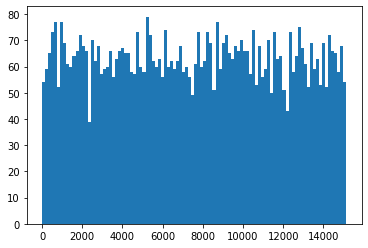

In [380]:
dataframe2_values = dataframe2.values
idx = 0
plt.hist(dataframe2_values[:, idx], bins=100);

### Plotando o histograma do conjunto de dados normalizado.

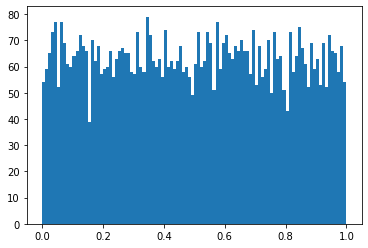

In [381]:
norm = preprocessing.MinMaxScaler()
dataframe2_norm = norm.fit_transform(dataframe2_values)
plt.hist(dataframe2_norm[:, idx], bins=100);

### Plotando o histograma do conjunto de dados padronizado.

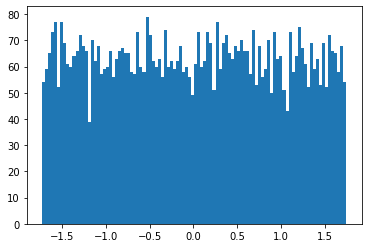

In [382]:
std = preprocessing.StandardScaler()
dataframe2_std= std.fit_transform(dataframe2_values)
plt.hist(dataframe2_std[:, idx], bins=100);

### Aplicando o kmeans para valores de k variando de 1 a 25, com os dados sem escalonamento, com o MinMaxScaler e depois com o StandardScaler.

### Os valores de inertia são observados e os resultados para cada modelo são armazenados em uma lista.

In [383]:
results_kmeans = []
k_values = np.arange(1, 26)
scalers = ['No Scaler', 'MinMaxScaler', 'StandardScaler']

for scaler in scalers:
    if scaler == 'No Scaler':
        df = dataframe2_values
    elif scaler == 'MinMaxScaler':
        df = dataframe2_norm
    else:
        df = dataframe2_std

    for k in k_values:
        cluster = KMeans(n_clusters=k, random_state=42)
        cluster.fit(df)
        resultado = {'Model': 'KMeans', 'Value of k': k, 'SSE': cluster.inertia_, 'Scaler': scaler}
        print(f'Escalonador: {scaler}')
        print(f'KMeans(k = {k})')
        print(f'Valor de Inertia: {cluster.inertia_}')
        print("\n---------------------------------------------------------------\n")
        results_kmeans.append(resultado)

Escalonador: No Scaler
KMeans(k = 1)
Valor de Inertia: 123824524051.88393

---------------------------------------------------------------

Escalonador: No Scaler
KMeans(k = 2)
Valor de Inertia: 33511565534.35736

---------------------------------------------------------------

Escalonador: No Scaler
KMeans(k = 3)
Valor de Inertia: 17004887616.885511

---------------------------------------------------------------

Escalonador: No Scaler
KMeans(k = 4)
Valor de Inertia: 10805603944.488314

---------------------------------------------------------------

Escalonador: No Scaler
KMeans(k = 5)
Valor de Inertia: 8198199761.418924

---------------------------------------------------------------

Escalonador: No Scaler
KMeans(k = 6)
Valor de Inertia: 6737584624.367048

---------------------------------------------------------------

Escalonador: No Scaler
KMeans(k = 7)
Valor de Inertia: 5857971287.021695

---------------------------------------------------------------

Escalonador: No Scaler
K

### Montando um dataframe com os resultados dos modelos kmeans.

### Ordenando o dataframe pelo parâmetro SSE.

In [384]:
df_results = pd.DataFrame(results_kmeans)
df_sorted_results = df_results.sort_values(by='SSE')
df_sorted_results.head(5)

Model  Value of k          SSE        Scaler
49  KMeans          25  1918.019300  MinMaxScaler
48  KMeans          24  1951.191288  MinMaxScaler
47  KMeans          23  1974.447064  MinMaxScaler
46  KMeans          22  2018.722689  MinMaxScaler
45  KMeans          21  2056.797457  MinMaxScaler

### Observando os modelos que atingiram os maiores valores de inertia.

In [385]:
df_sorted_results.tail(5)

Model  Value of k           SSE     Scaler
4  KMeans           5  8.198200e+09  No Scaler
3  KMeans           4  1.080560e+10  No Scaler
2  KMeans           3  1.700489e+10  No Scaler
1  KMeans           2  3.351157e+10  No Scaler
0  KMeans           1  1.238245e+11  No Scaler

### Plotando os gráficos com os valores de inertias para os modelos com e sem escalonamento e observando a variação desse dado a medida que o valor de k aumenta.

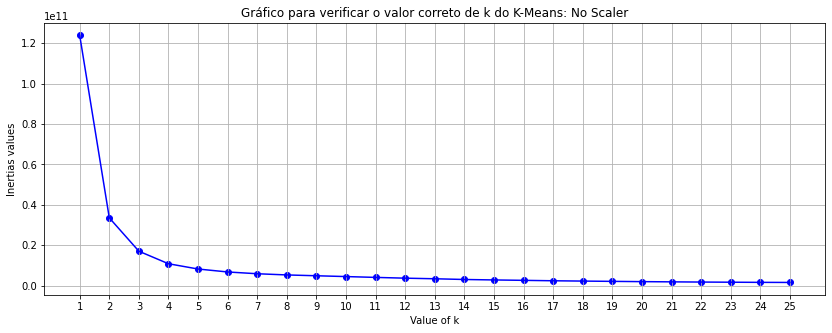

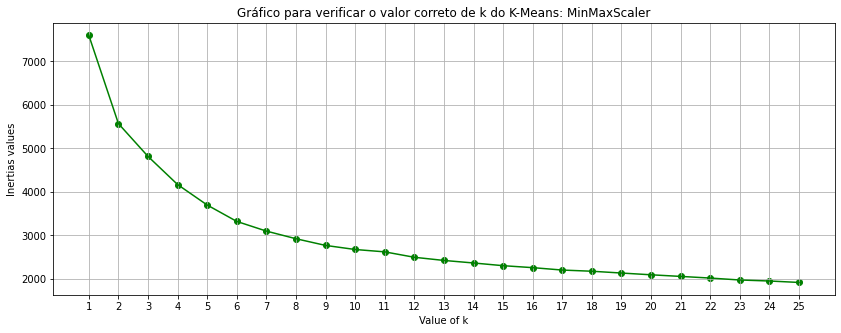

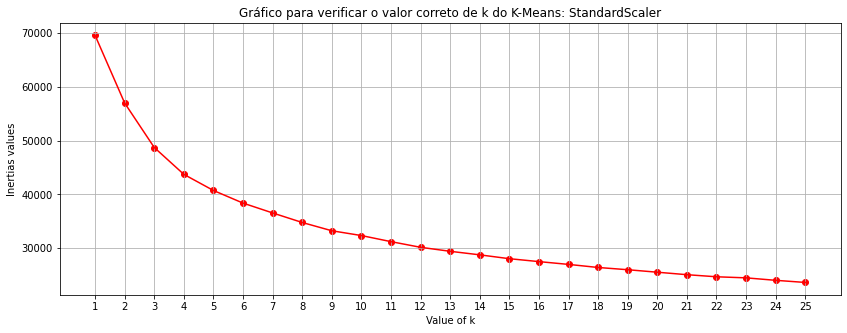

In [386]:
inertias_noScaler = df_results.loc[df_results['Scaler'] == 'No Scaler', 'SSE']
inertias_norm = df_results.loc[df_results['Scaler'] == 'MinMaxScaler', 'SSE']
inertias_std = df_results.loc[df_results['Scaler'] == 'StandardScaler', 'SSE']

inertias = [inertias_noScaler, inertias_norm, inertias_std]
colors = ['blue', 'green', 'red']

for inertia_values, scaler, color in zip(inertias, scalers, colors): 
  plt.figure(figsize = (14, 5))
  plt.plot(k_values, inertia_values, c=color)
  plt.ylabel('Inertias values')
  plt.xlabel('Value of k')
  plt.title(f'Gráfico para verificar o valor correto de k do K-Means: {scaler}')
  plt.scatter(k_values, inertia_values, c=color)
  plt.xticks(k_values)
  plt.grid()
  plt.show()


### Utilizando o PCA para reduzir a dimensionalidade do dataset, para que os grupos possam ser exibidos em gráficos.

In [387]:
dataframe2_norm_values = dataframe2_norm
pca = PCA(n_components=2)

novos_valores = pca.fit_transform(dataframe2_norm_values)
novos_valores

array([[-0.30982064, -0.28041906],
       [-0.37549102, -0.14125483],
       [-0.40226098, -0.10570873],
       ...,
       [ 0.1144438 , -0.79137541],
       [ 0.12647559, -0.76381359],
       [ 0.39107954, -0.48645586]])

### Montando um dataframe com as novas features criadas pelo PCA.

In [388]:
dataframe_values = { 'feature1': novos_valores[:,0], 'feature2': novos_valores[:,1] }
dataframe3 = pd.DataFrame(dataframe_values)
dataframe3

feature1  feature2
0    -0.309821 -0.280419
1    -0.375491 -0.141255
2    -0.402261 -0.105709
3    -0.321927 -0.019871
4    -0.841720 -0.223051
...        ...       ...
6316  0.381829  0.713496
6317 -0.198989 -0.248764
6318  0.114444 -0.791375
6319  0.126476 -0.763814
6320  0.391080 -0.486456

[6321 rows x 2 columns]

### Plotando todos os dados desse dataset.

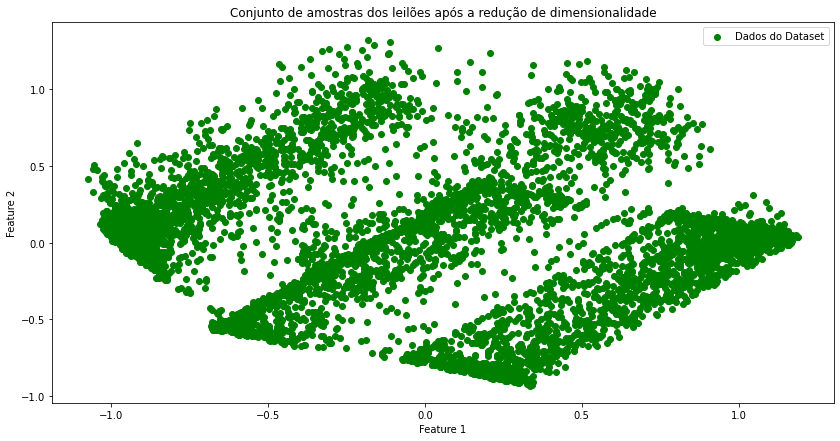

In [389]:
plt.figure(figsize=(14, 7))

plt.scatter(dataframe3['feature1'], dataframe3['feature2'], color="Green")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Conjunto de amostras dos leilões após a redução de dimensionalidade')
plt.legend(['Dados do Dataset'])
plt.show()

### Criando um novo modelo de KMeans com o valor do número de clusters igual a 2, de acordo com o que foi verificado pelo gráfico dos valores de inertias.

In [390]:
new_model = KMeans(n_clusters=2, random_state=142)
clusters = new_model.fit(dataframe3)
labels = clusters.labels_
labels

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

### Apresentando a quantidade de amostras para cada classe retornada pelo KMeans.

In [391]:
class0 = np.sum(labels == 0)
class1 = np.sum(labels == 1)
print(f'Total de amostras da classe 0: {class0}')
print(f'Total de amostras de classe 1: {class1}')

Total de amostras da classe 0: 3232
Total de amostras de classe 1: 3089


### Adicionando uma nova coluna no dataframe para representar as classes em que os dados foram agrupados pelo KMeans. 

In [392]:
dataframe3['class'] = labels
dataframe3.head() 

feature1  feature2  class
0 -0.309821 -0.280419      1
1 -0.375491 -0.141255      1
2 -0.402261 -0.105709      1
3 -0.321927 -0.019871      1
4 -0.841720 -0.223051      1

### Exibindo os pontos centrais de cada grupo.

In [393]:
centers = clusters.cluster_centers_
centers

array([[ 0.54169231, -0.05491721],
       [-0.56784661,  0.05756876]])

### Plotando um gráfico com os pontos pintados de acordo com as classes na qual eles foram agrupados.



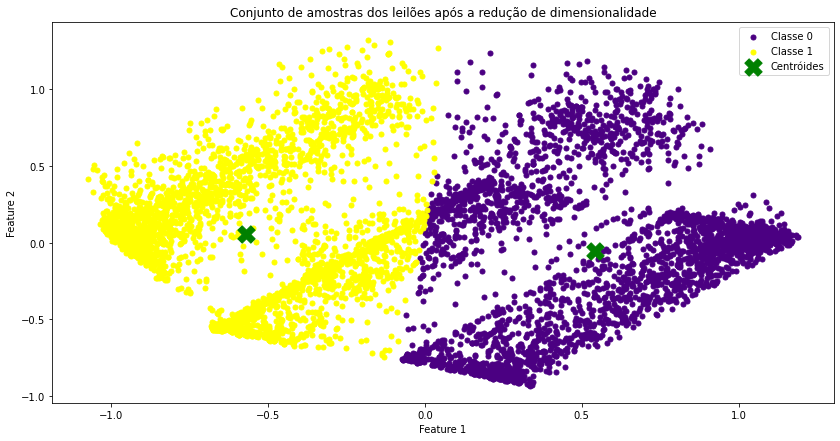

In [394]:
plt.figure(figsize=(14, 7))

f1_c0 = dataframe3.iloc[labels == 0, 0]
f2_c0 = dataframe3.iloc[labels == 0, 1]
f1_c1 = dataframe3.iloc[labels == 1, 0]
f2_c1 = dataframe3.iloc[labels == 1, 1]

c0 = plt.scatter(f1_c0, f2_c0, s=25, c='indigo')
c1 = plt.scatter(f1_c1, f2_c1, s=25, c='yellow')
cnt = plt.scatter(centers[:, 0], centers[:, 1], marker='X', c='green', s=300)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Conjunto de amostras dos leilões após a redução de dimensionalidade')
plt.legend([c0, c1, cnt], ['Classe 0', 'Classe 1', 'Centróides'])
plt.show()

### Plotando o Dendrograma dos dados desse dataset.

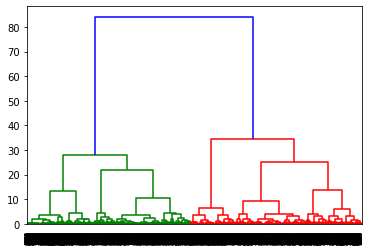

In [395]:
data = hierarchy.ward(dataframe3)
dn = hierarchy.dendrogram(data)

### Criando modelos de AgglomerativeClustering para valores de número de clusters variando de 10 a 1 e utilizando o linkage ward. 

### Plotando os gráficos com os grupos para cada modelo criado.

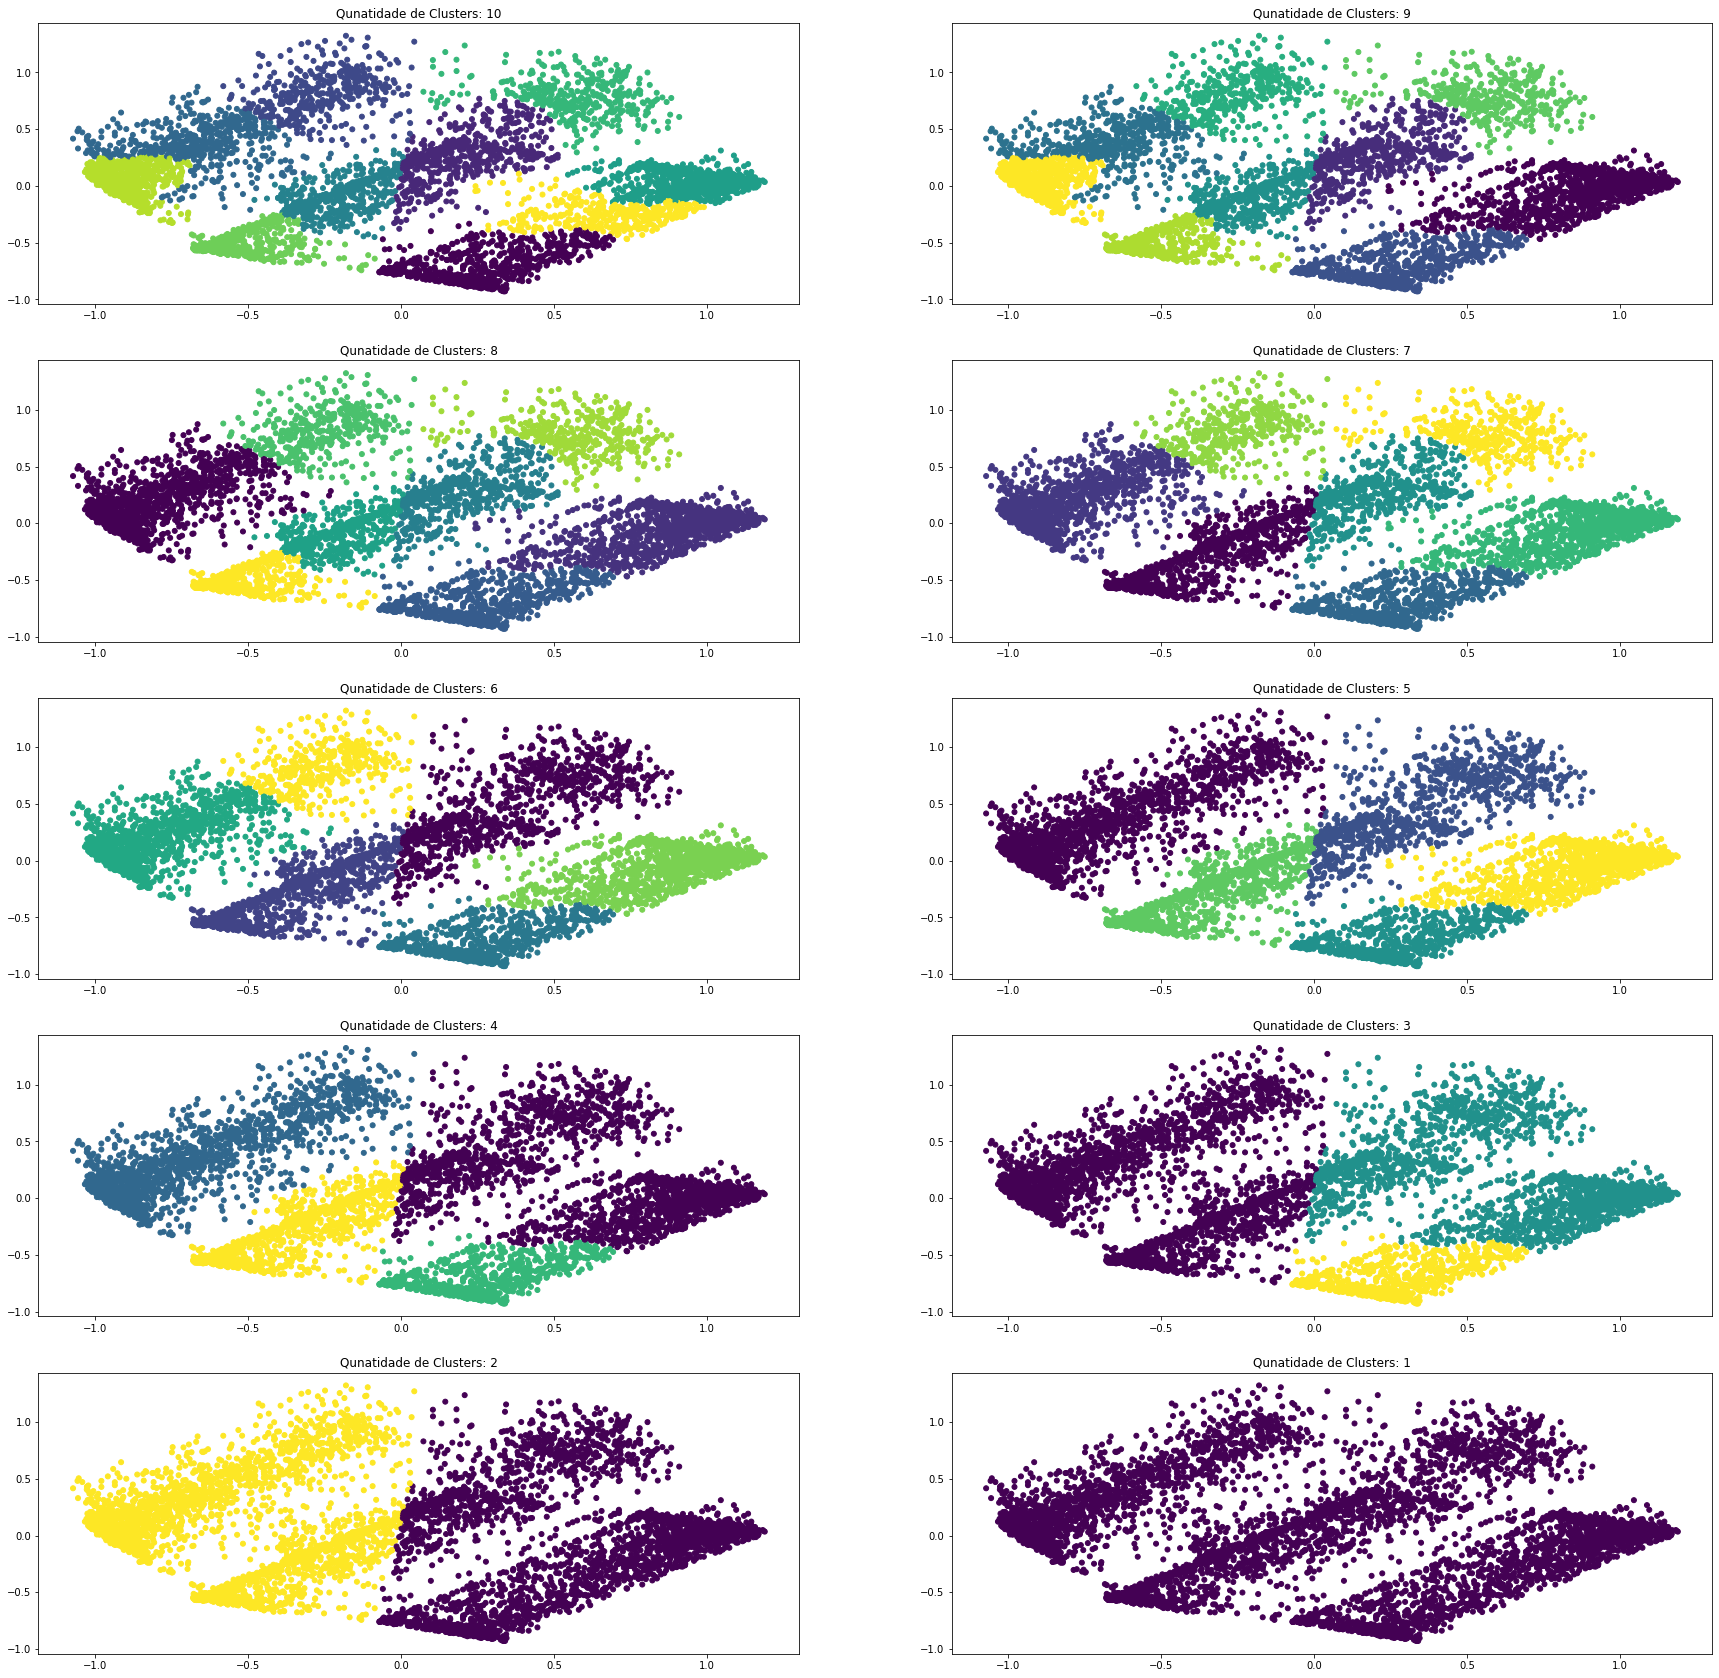

In [396]:
n_clusters_max = 10

cols = 2
rows = int(np.ceil(n_clusters_max / cols))


fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(30,30))


row = 0
col = 0

for n in range(n_clusters_max, 0, -1):
    model = AgglomerativeClustering(linkage='ward', n_clusters=n)
    clusters = model.fit(dataframe3)
    labels = clusters.labels_
    
    ax[row, col].scatter(dataframe3.iloc[:,0], dataframe3.iloc[:,1], c=labels, s=25)
    ax[row, col].set_title(f'Qunatidade de Clusters: {n}')

    col += 1
    
    if col == cols:
      col = 0
      row += 1  
    

plt.show()

### Criando modelos de AgglomerativeClustering para valores de número de clusters variando de 10 a 1 e utilizando o linkage complete. 

### Plotando os gráficos com os grupos para cada modelo criado.

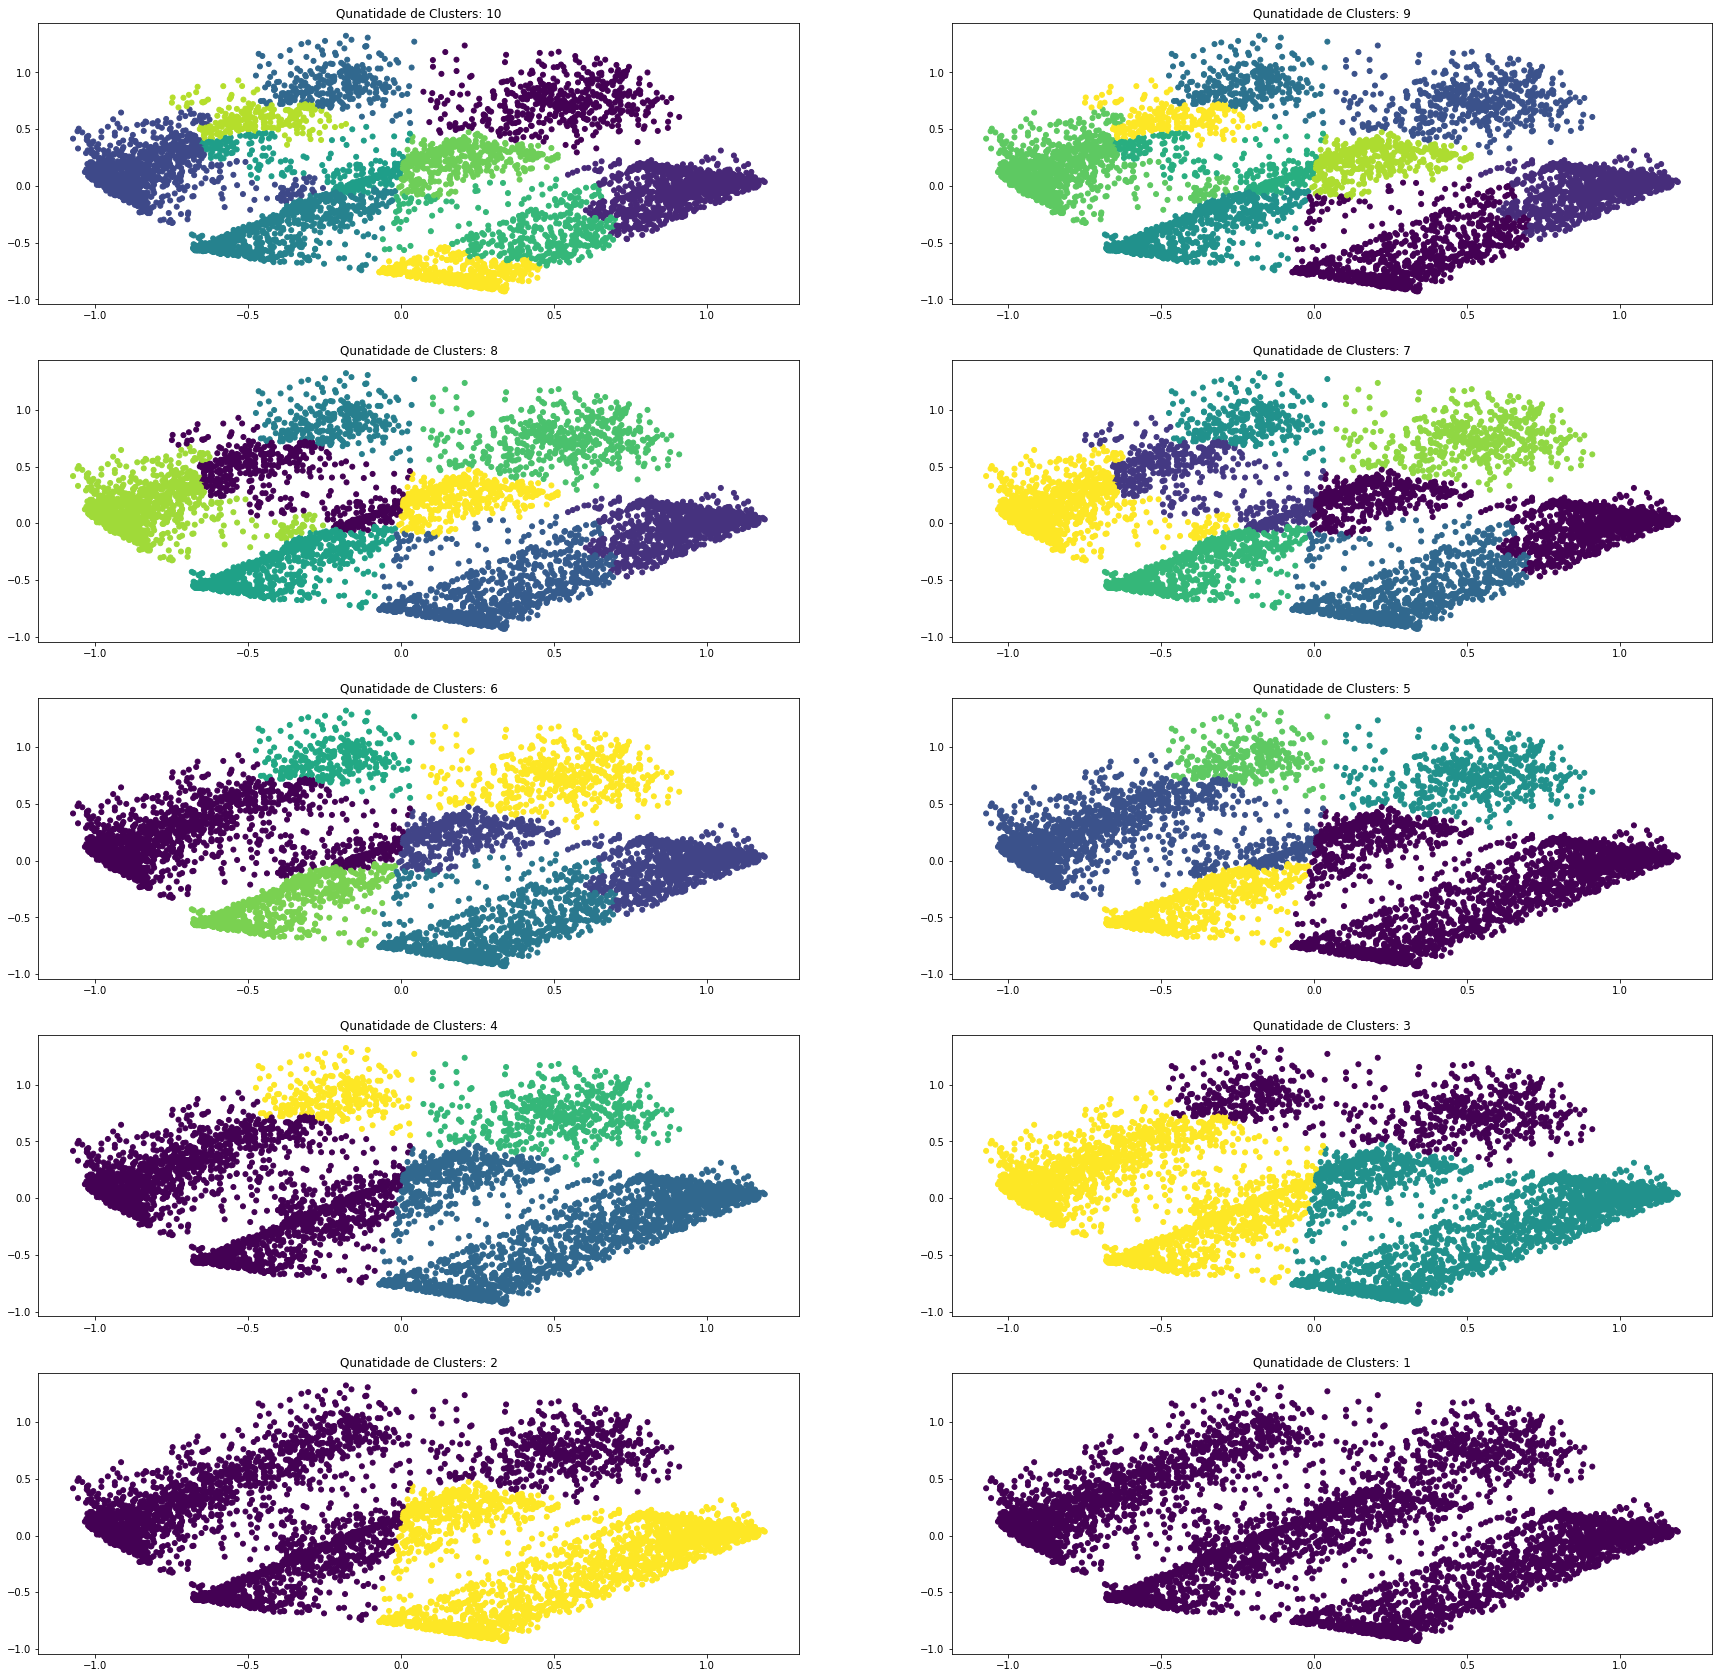

In [397]:
n_clusters_max = 10

cols = 2
rows = int(np.ceil(n_clusters_max / cols))


fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(30,30))


row = 0
col = 0

for n in range(n_clusters_max, 0, -1):
    model = AgglomerativeClustering(linkage='complete', n_clusters=n)
    clusters = model.fit(dataframe3)
    labels = clusters.labels_
    
    ax[row, col].scatter(dataframe3.iloc[:,0], dataframe3.iloc[:,1], c=labels, s=25)
    ax[row, col].set_title(f'Qunatidade de Clusters: {n}')

    col += 1
    
    if col == cols:
      col = 0
      row += 1  
    

plt.show()

### Criando um modelo de AgglomerativeClustering, utilizando o linkage ward e o número de clusters igual a 2.

In [398]:
model = AgglomerativeClustering(linkage='ward', n_clusters=2)
clusters = model.fit(dataframe3)
labels = clusters.labels_
labels

array([1, 1, 1, ..., 0, 0, 0])

### Apresentando a quantidade de amostras para cada classe retornada pelo KMeans.

In [399]:
class0 = np.sum(labels == 0)
class1 = np.sum(labels == 1)
print(f'Total de amostras da classe 0: {class0}')
print(f'Total de amostras de classe 1: {class1}')

Total de amostras da classe 0: 3232
Total de amostras de classe 1: 3089


### Plotando um gráfico com os pontos pintados de acordo com as classes na qual eles foram agrupados.

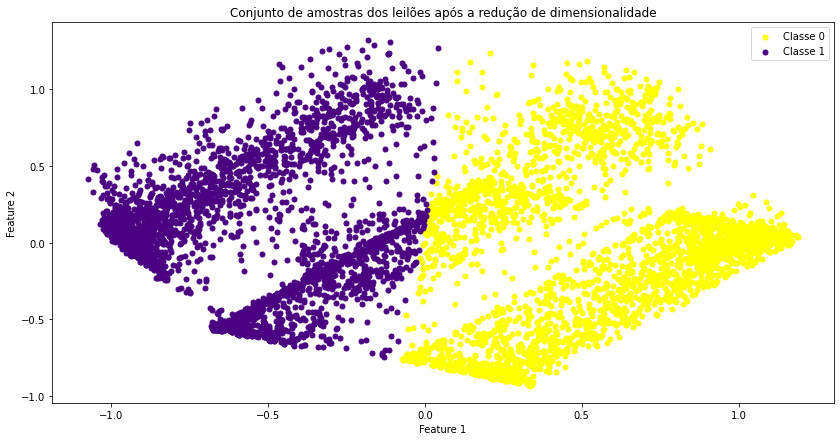

In [400]:
plt.figure(figsize=(14, 7))

f1_c0 = dataframe3.iloc[labels == 0, 0]
f2_c0 = dataframe3.iloc[labels == 0, 1]
f1_c1 = dataframe3.iloc[labels == 1, 0]
f2_c1 = dataframe3.iloc[labels == 1, 1]

c0 = plt.scatter(f1_c0, f2_c0, s=25, c='yellow')
c1 = plt.scatter(f1_c1, f2_c1, s=25, c='indigo')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Conjunto de amostras dos leilões após a redução de dimensionalidade')
plt.legend([c0, c1], ['Classe 0', 'Classe 1'])

plt.show()

### Criando um modelo com o DBSCAN e escolhendo os parâmetros de distância para os pontos vizinhos e a quantidade de amostras mínimas para que um ponto seja considerado um ponto de núcleo. 

### A quantidade de cada classe é observada e também a quantidade de amostras que foram consideradas pelo algoritmo como ruídos.

In [401]:
dbscan = DBSCAN(eps=0.15, min_samples=45)
clusters = dbscan.fit(dataframe3)
labels = clusters.labels_
dataframe2["label"] = labels
dataframe2["label"].value_counts()

 1    3210
 0    3062
-1      49
Name: label, dtype: int64

### Observando o dataframe com a adição da coluna label que representa a classe de cada linha do dataset.

In [402]:
dataframe2

Record_ID  Auction_ID  ...  Auction_Duration  label
0             1         732  ...                 5      0
1             2         732  ...                 5      0
2             3         732  ...                 5      0
3             4         732  ...                 5      0
4             5         900  ...                 7      0
...         ...         ...  ...               ...    ...
6316      15129         760  ...                 3      1
6317      15137        2481  ...                 7      0
6318      15138        2481  ...                 7      1
6319      15139        2481  ...                 7      1
6320      15144        2481  ...                 7      1

[6321 rows x 12 columns]

### Plotando um gráfico com os pontos pintados de acordo com as classes na qual eles foram agrupados e também os dados considerados como ruídos.

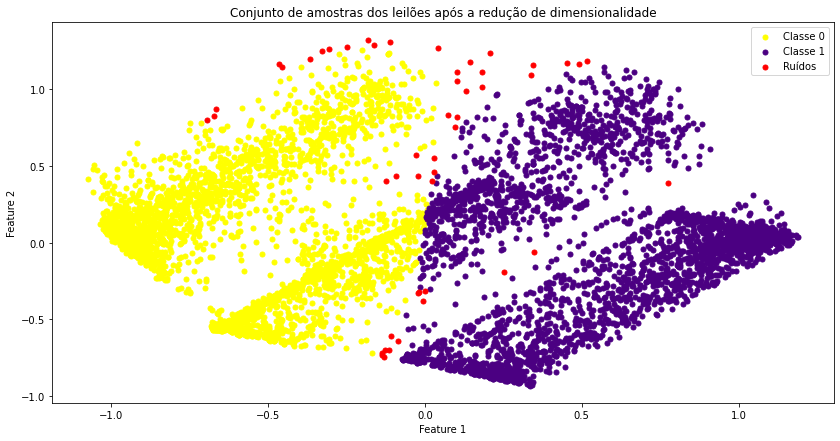

In [403]:
plt.figure(figsize=(14, 7))

f1_c0 = dataframe3.iloc[labels == 0, 0]
f2_c0 = dataframe3.iloc[labels == 0, 1]
f1_c1 = dataframe3.iloc[labels == 1, 0]
f2_c1 = dataframe3.iloc[labels == 1, 1]
f1_r = dataframe3.iloc[labels == -1, 0]
f2_r = dataframe3.iloc[labels == -1, 1]

c0 = plt.scatter(f1_c0, f2_c0, s=25, c='yellow')
c1 = plt.scatter(f1_c1, f2_c1, s=25, c='indigo')
r = plt.scatter(f1_r, f2_r, s=25, c='red')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Conjunto de amostras dos leilões após a redução de dimensionalidade')
plt.legend([c0, c1, r], ['Classe 0', 'Classe 1', 'Ruídos'])

plt.show()